In [1]:
%run ../../bin/imports.ipynb

In [2]:
import statistics


## Pan-cancer analysis

In [3]:
data_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/pancancer.merged_data.tab', 
                 sep='\t')
data_df['Has_HLALOH'] = ~data_df['Alleles_lost'].isnull()

In [4]:
len(data_df)

609

In [5]:
columns = list(data_df.columns)

In [6]:
# Cancer types with at least 10 patients with HLA LOH
cancer_types = list(data_df[data_df.Has_HLALOH].Cancer_type.value_counts()
                    [data_df[data_df.Has_HLALOH].Cancer_type.value_counts() >= 8].index)
print(len(cancer_types))

# All cancer types
len(data_df.Cancer_type.unique())
print(data_df.Cancer_type.unique())

7
['Bladder' 'Melanoma' 'Colorectal' 'Pancreatic' 'Uterine' 'Head_Neck'
 'Cervical' 'NSCLC_SCC' 'Liver' 'NSCLC_adenocarcinoma' 'Breast' 'Thyroid'
 'Kidney_RCC' 'Ovarian' 'Lung-LCC']


### Cohort summary figures

In [7]:
columns[:10]

['sample_name_tumor',
 'AJCC_UICC_Stage_Group',
 'Cancer_type',
 'Simple_Stage',
 'purity',
 'MATH',
 'MSI_percentage',
 'Cytolytic_score',
 'CD274',
 'CASP8']

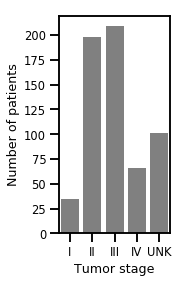

In [8]:
plt.figure(figsize=(2, 4))
sns.set_context('talk', font_scale=0.7)

sns.countplot(x='Simple_Stage', data=data_df,
             order=['I', 'II', 'III', 'IV', 'UNK'],
             color='grey')
plt.ylabel('Number of patients')
plt.xlabel('Tumor stage')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.tumor_stage.2021_06_25.pdf',
           bbox_inches='tight')

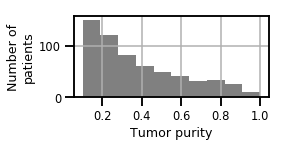

In [9]:
plt.figure(figsize=(3.5, 1.5))
sns.set_context('talk', font_scale=0.7)

data_df.purity.hist(color='grey')
plt.ylabel('Number of\npatients')
plt.xlabel('Tumor purity')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.tumor_purity.2021_06_25.pdf',
           bbox_inches='tight')

In [10]:
data_df.purity.median()

0.31

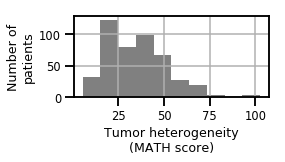

In [11]:
plt.figure(figsize=(3.5, 1.5))
sns.set_context('talk', font_scale=0.7)

data_df.MATH.hist(color='grey')
plt.ylabel('Number of\npatients')
plt.xlabel('Tumor heterogeneity\n(MATH score)')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.heterogeneity.2021_06_25.pdf',
           bbox_inches='tight')

In [12]:
data_df.MATH.median()

32.78449412

In [13]:
data_df['Allele_lost_A'] = data_df['Alleles_lost'].str.contains('A').fillna(False).astype(int)
data_df['Allele_lost_B'] = data_df['Alleles_lost'].str.contains('B').fillna(False).astype(int)
data_df['Allele_lost_C'] = data_df['Alleles_lost'].str.contains('C').fillna(False).astype(int)


In [14]:
lost_alleles_list = list(data_df['Alleles_lost'])

lost_allele_counter = {}

for sample in lost_alleles_list:
    if type(sample) is not float:
#         print(sample)
        allele_list = sample.split(',')
        for allele in allele_list:
            if allele not in lost_allele_counter:
                lost_allele_counter[allele] = 1
            else:
                lost_allele_counter[allele] = lost_allele_counter[allele] + 1
                
# print(lost_allele_counter)


kept_alleles_list = list(data_df['Alleles_retained'])

kept_allele_counter = {}

for sample in kept_alleles_list:
    if type(sample) is not float:
#         print(sample)
        allele_list = sample.split(',')
        for allele in allele_list:
            if allele not in kept_allele_counter:
                kept_allele_counter[allele] = 1
            else:
                kept_allele_counter[allele] = kept_allele_counter[allele] + 1
                
# print(kept_allele_counter)


In [15]:
# get list of all unique alleles to use as column in new dataframe
unique_alleles = []
for allele in lost_allele_counter:
    if allele not in unique_alleles:
        unique_alleles.append(allele)
for allele in kept_allele_counter:
    if allele not in unique_alleles:
        unique_alleles.append(allele)

print(len(unique_alleles))

allele_dataframe = pd.DataFrame()
allele_dataframe['Allele'] = unique_alleles

def get_lost(row, lost_alleles):
    lost_allele_count = 0
    if row['Allele'] in lost_alleles:
        lost_allele_count = lost_alleles[row['Allele']]
    return lost_allele_count

def get_kept(row, kept_alleles):
    kept_allele_count = 0
    if row['Allele'] in kept_alleles:
        kept_allele_count = kept_alleles[row['Allele']]
    return kept_allele_count

def get_total(row):
    total = row['Lost_count'] + row['Kept_count']
    return total

def get_frequency_lost_allele(row):    
    try:
        frequency = row['Lost_count']/row['Total_allele_count']
    except Exception as e:
        frequency = 0
    return frequency
    
def get_frequency_of_allele(row):
    try:
        frequency = row['Total_allele_count']/row['Total_count']
    except Exception as e:
        frequency = 0
    return frequency

# counts
allele_dataframe['Lost_count'] = allele_dataframe.apply(lambda row: get_lost(row, lost_allele_counter), axis=1)
allele_dataframe['Kept_count'] = allele_dataframe.apply(lambda row: get_kept(row, kept_allele_counter), axis=1)

# count total # of each allele that "exists"
allele_list = list(allele_dataframe['Allele'])
total_allele_counts = []

for allele in allele_list:
    try:
        allele_exists_column = F"{allele}_exists"
        total_allele_count = np.nansum(list(data_df[allele_exists_column]))
#         print(list(data_df[allele_exists_column]))
        total_allele_counts.append(total_allele_count)
    except Exception as e:
        total_allele_counts.append(0)
        print(e)
allele_dataframe['Total_allele_count'] = total_allele_counts

# add list to allele_dataframe['total_allele_count']

allele_dataframe['Total_count'] = sum(list(allele_dataframe['Total_allele_count']))
# frequencies
allele_dataframe['Lost_allele_frequency'] = allele_dataframe.apply(lambda row: get_frequency_lost_allele(row), axis=1)
allele_dataframe['Allele_frequency'] = allele_dataframe.apply(lambda row: get_frequency_of_allele(row), axis=1)

# print(max(allele_dataframe['Total_frequency']))

allele_dataframe.head()


168
'A*02:13_exists'
'A*01:22_exists'


Allele  Lost_count  Kept_count  Total_allele_count  Total_count  \
0  A*32:01           5          24                31.0       3434.0   
1  B*53:01           1           7                 9.0       3434.0   
2  C*04:01           9         105               123.0       3434.0   
3  A*23:01           1          14                15.0       3434.0   
4  A*31:01           7          21                28.0       3434.0   

   Lost_allele_frequency  Allele_frequency  
0               0.161290          0.009027  
1               0.111111          0.002621  
2               0.073171          0.035818  
3               0.066667          0.004368  
4               0.250000          0.008154

In [16]:
# get only the datapoints w/ a frequency & not 0
# frequency_allele_dataframe = allele_dataframe[allele_dataframe['Lost_allele_frequency'] != 0]
frequency_allele_dataframe = allele_dataframe

# get only datapoints w/ a total_allele_count of >= median(all total_allele_counts)
count_cutoff = statistics.median(list(frequency_allele_dataframe['Total_allele_count']))
print(count_cutoff)
frequency_allele_dataframe = frequency_allele_dataframe[frequency_allele_dataframe['Total_allele_count'] >= count_cutoff]
frequency_allele_dataframe = frequency_allele_dataframe.reset_index()
frequency_allele_dataframe = frequency_allele_dataframe.sort_values("Allele_frequency", ascending=False)
frequency_allele_dataframe.head()

6.0


index   Allele  Lost_count  Kept_count  Total_allele_count  Total_count  \
13     15  A*02:01          12         175               235.0       3434.0   
6       7  C*07:02          11         119               140.0       3434.0   
9      11  A*24:02           8         113               133.0       3434.0   
2       2  C*04:01           9         105               123.0       3434.0   
8      10  C*06:02          11          96               117.0       3434.0   

    Lost_allele_frequency  Allele_frequency  
13               0.051064          0.068433  
6                0.078571          0.040769  
9                0.060150          0.038730  
2                0.073171          0.035818  
8                0.094017          0.034071

0.16612397913597002


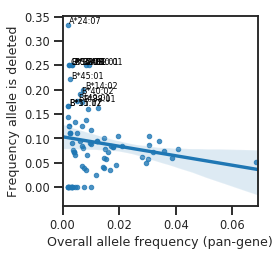

In [17]:
plt.figure(figsize=(3.5, 3.5))
sns.set_context('talk', font_scale=0.7)


frequency_mean = statistics.mean(list(frequency_allele_dataframe['Lost_allele_frequency']))
# frequency_pvar = statistics.pvariance(list(frequency_allele_dataframe['Lost_allele_frequency']))
# where do we want this cutoff to be?
# frequency_cutoff = frequency_mean 

frequency_median = statistics.median(list(frequency_allele_dataframe['Lost_allele_frequency']))
frequency_stdev = statistics.stdev(list(frequency_allele_dataframe['Lost_allele_frequency']))
frequency_cutoff = frequency_mean + frequency_stdev
print(frequency_cutoff)

sns.set_context('talk', font_scale=0.7)
sns.set_style("ticks")

ax = sns.regplot(data=frequency_allele_dataframe, x="Allele_frequency", y="Lost_allele_frequency",
                marker='.')
ax.set(xlim=(0, 0.069))
#plt.xticks(rotation=30)
plt.xlabel('Overall allele frequency (pan-gene)')
plt.ylabel('Frequency allele is deleted')

for i in range(frequency_allele_dataframe.shape[0]):
    if frequency_allele_dataframe.Lost_allele_frequency[i] > frequency_cutoff:
        plt.text(x=frequency_allele_dataframe.Allele_frequency[i]+0.0006,y=frequency_allele_dataframe.Lost_allele_frequency[i]+0.001,s=frequency_allele_dataframe.Allele[i], 
                fontdict=dict(color='black',size=8))

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.frequency_of_deletion.2021_06_25.pdf',
           bbox_inches='tight')

### Frequency across tumor types

In [18]:
data_df.Has_HLALOH.mean()

0.17898193760262726

In [19]:
data_df.columns

Index(['sample_name_tumor', 'AJCC_UICC_Stage_Group', 'Cancer_type',
       'Simple_Stage', 'purity', 'MATH', 'MSI_percentage', 'Cytolytic_score',
       'CD274', 'CASP8',
       ...
       'Potential_neoantigens', 'Potential_neoepitopes',
       'BINDING_antigen_strong_count', 'BINDING_epitope_strong_count',
       'PRESENTATION_antigen_strong_count',
       'PRESENTATION_epitope_strong_count', 'Has_HLALOH', 'Allele_lost_A',
       'Allele_lost_B', 'Allele_lost_C'],
      dtype='object', length=752)

In [20]:
total_df = data_df.Cancer_type.value_counts().reset_index()
total_df.columns = ['Cancer_type', 'Total_patients']

In [21]:
loh_df = data_df[data_df.Has_HLALOH].Cancer_type.value_counts().reset_index()
loh_df.columns = ['Cancer_type', 'HLALOH_patients']

In [22]:
freq_df = pd.merge(total_df, loh_df, on='Cancer_type', how='left').fillna(0)

In [23]:
freq_df['Fraction'] = freq_df['HLALOH_patients'] / freq_df['Total_patients']

In [24]:
cancer_type_map = {'Cervical': 'Cervical', 'Head_Neck': 'HNSCC', 'NSCLC_SCC': 'NSCLC-SCC',
                   'NSCLC_adenocarcinoma': 'NSCLC-A', 'Pancreatic': 'Pancreatic',
                   'Bladder': 'Blader', 'Colorectal': 'Colorectal', 'Kidney_RCC': 'Kidney',
                   'Breast': 'Breast', 'Melanoma': 'Melanoma', 'Ovarian': 'Ovarian',
                   'Uterine': 'Uterine', 'Liver':'Liver'}

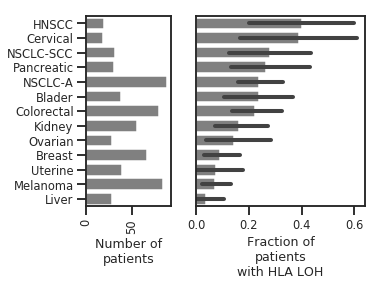

In [25]:
size_constraint = freq_df.Total_patients > 10

plt.figure(figsize=(5, 3.5))
sns.set_context('talk', font_scale=0.7)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 


ax0 = plt.subplot(gs[1])
sns.barplot(y='Cancer_type', x='Has_HLALOH', data=data_df, color='grey', 
            order=freq_df[size_constraint].sort_values('Fraction', ascending=False).Cancer_type, ax = ax0)
plt.xlabel('Fraction of\npatients\nwith HLA LOH')
plt.yticks([])
plt.ylabel('')

ax1 = plt.subplot(gs[0])
sns.barplot(y='Cancer_type', x='Total_patients', data=freq_df, color='grey', 
            order=freq_df[size_constraint].sort_values('Fraction', ascending=False).Cancer_type, ax=ax1)
plt.xticks(rotation=90)
plt.xlabel('Number of\npatients')
ax1.set(yticklabels=[cancer_type_map[x] for x in 
                     list(freq_df[size_constraint].sort_values('Fraction', ascending=False).Cancer_type)])
plt.ylabel('')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.frequency_of_hlaloh.2021_06_25.pdf',
           bbox_inches='tight')

In [26]:
freq_df.Total_patients.sum()

609

In [27]:
freq_df.sort_values('Fraction')

Cancer_type  Total_patients  HLALOH_patients  Fraction
13               Thyroid               2              0.0  0.000000
14              Lung-LCC               1              0.0  0.000000
9                  Liver              28              1.0  0.035714
1               Melanoma              84              6.0  0.071429
5                Uterine              39              3.0  0.076923
3                 Breast              66              6.0  0.090909
10               Ovarian              28              4.0  0.142857
4             Kidney_RCC              55              9.0  0.163636
2             Colorectal              80             18.0  0.225000
6                Bladder              38              9.0  0.236842
0   NSCLC_adenocarcinoma              88             21.0  0.238636
8             Pancreatic              30              8.0  0.266667
7              NSCLC_SCC              32              9.0  0.281250
12              Cervical              18              7.0  0.388889
11             Head_Neck              20              8.0  0.400000

In [28]:
freq_df.columns = ['Cancer Type', 'Total Patients', 'Patients with HLA LOH', 'Fraction of Patients with HLA LOH']

In [29]:
# Save table to file
freq_df.sort_values('Fraction of Patients with HLA LOH', ascending=False).to_excel('/rnd/users/rpyke/data/00-DASH/tables/Table_S5_hla_loh_frequencies.xlsx', index=None)


In [30]:
# Update
8 / 13

0.6153846153846154

### Check # of alleles lost if starting with only heterozygous patients

In [31]:
data_df['Allele_lost_A'] = data_df['Alleles_lost'].str.contains('A').fillna(False).astype(int)
data_df['Allele_lost_B'] = data_df['Alleles_lost'].str.contains('B').fillna(False).astype(int)
data_df['Allele_lost_C'] = data_df['Alleles_lost'].str.contains('C').fillna(False).astype(int)

In [32]:
# restrict to fully heterozygous alleles
heterozygous_data_df = data_df[data_df.Alleles_homozygous.isna()]

In [33]:
gene_count_df = heterozygous_data_df[['Allele_lost_A', 'Allele_lost_B', 'Allele_lost_C']].sum(axis=1) \
                        .value_counts().reset_index()
gene_count_df.columns = ['Number of HLA genes with LOH', 'Number of patients']

In [34]:
gene_count_df.head()

Number of HLA genes with LOH  Number of patients
0                             0                 354
1                             3                  65
2                             1                  17
3                             2                   3

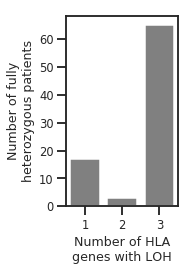

In [35]:
plt.figure(figsize=(2, 3.5))
sns.set_context('talk', font_scale=0.7)
sns.barplot(x='Number of HLA genes with LOH', y='Number of patients', data=gene_count_df,
           order=[1, 2, 3], color='grey')
plt.xticks(rotation=0)
plt.ylabel('Number of fully\nheterozygous patients')
plt.xlabel('Number of HLA\ngenes with LOH')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.number_of_genes_impacted.2021_06_25.pdf',
           bbox_inches='tight')

In [36]:
print(65 / (65+17+3))
print(3 / (65+17+3))
print(18 / (65+17+3))

0.7647058823529411
0.03529411764705882
0.21176470588235294


In [37]:
gene_specific_df = heterozygous_data_df[['Allele_lost_A', 'Allele_lost_B', 'Allele_lost_C']].sum().reset_index()

In [38]:
gene_specific_df['Gene'] = gene_specific_df['index'].str.split('_').str[2]

In [39]:
gene_specific_df.columns = ['index', 'Number_lost', 'Gene']

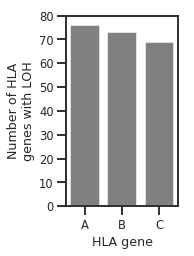

In [40]:
plt.figure(figsize=(2, 3.5))
sns.set_context('talk', font_scale=0.7)
sns.barplot(x='Gene', y='Number_lost', data=gene_specific_df,
           order=['A', 'B', 'C'], color='grey')
plt.xticks(rotation=0)
plt.ylabel('Number of HLA\ngenes with LOH')
plt.xlabel('HLA gene')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.which_genes_impacted.2021_06_25.pdf',
           bbox_inches='tight')

### CNV

In [41]:
green = '#77c722'
blue = '#3864b5'

In [42]:
len(data_df)

609

In [43]:
print('Pan-cancer:', sp.mannwhitneyu(data_df[data_df.Has_HLALOH].LOH_region,
               data_df[~data_df.Has_HLALOH].LOH_region))
print('With HLA LOH:', data_df[data_df.Has_HLALOH].LOH_region.median())
print('Without HLA LOH:', data_df[~data_df.Has_HLALOH].LOH_region.median())


for tumor_type in cancer_types:
    print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.Has_HLALOH].LOH_region,
           data_df[(data_df.Cancer_type == tumor_type)&~data_df.Has_HLALOH].LOH_region)[1]*len(cancer_types))


Pan-cancer: MannwhitneyuResult(statistic=12019.0, pvalue=2.835306561035477e-20)
With HLA LOH: 0.280441234375
Without HLA LOH: 0.1445645175
NSCLC_adenocarcinoma 0.0084282007223309
Colorectal 0.0015781147951099968
NSCLC_SCC 0.010227182034080328
Kidney_RCC 0.0006979597510717297
Bladder 0.007855552473674522
Pancreatic 0.161853385521899
Head_Neck 1.6225806402093652


In [44]:
data_df['HLA LOH'] = data_df['Has_HLALOH']

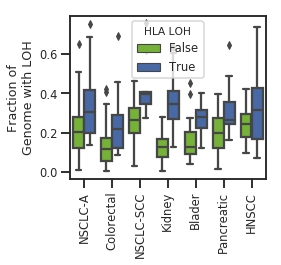

In [45]:
plt.figure(figsize=(3.5, 3))
sns.set_context('talk', font_scale=0.7)
g = sns.boxplot(x='Cancer_type', y='LOH_region', hue='HLA LOH', data=data_df, palette=[green, blue],
            order=cancer_types)
plt.xticks(rotation=90)
plt.ylabel('Fraction of\nGenome with LOH')
#plt.ylim(50, 200)
#plt.legend([])
g.set(xticklabels=[cancer_type_map[x] for x in cancer_types])
plt.xlabel('')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.fraction_of_genome_LOH.2021_06_25.pdf',
           bbox_inches='tight')

Patient-specific analysis

In [46]:
cnv_category = 'LOH_region'

In [47]:
total_length = 3200000000

In [48]:
hla_gene_length = 3000

In [49]:
hla_gene_length / total_length

9.375e-07

In [50]:
sp.mannwhitneyu(list(data_df[cnv_category]),
               list(data_df['HLA LOH'].astype(int)))

MannwhitneyuResult(statistic=66272.0, pvalue=1.975351072417448e-90)

In [51]:
data_df['HLA LOH'].astype(int).mean()

0.17898193760262726

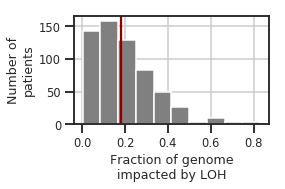

In [52]:
plt.figure(figsize=(3.5, 2))

data_df[cnv_category].hist(color='grey')

plt.axvline(data_df['HLA LOH'].astype(int).mean(), color='darkred')

plt.xlabel('Fraction of genome\nimpacted by LOH')
plt.ylabel('Number of\npatients')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.fraction_LOH_and_HLALOH_pancancer.2021_06_25.pdf',
           bbox_inches='tight')

In [53]:
data_df['HLA LOH'].astype(int).mean()

0.17898193760262726

In [54]:
data_df[cnv_category].median()

0.17121542609375

Tumor-type specific analysis

In [55]:
cnv_category = 'LOH_region'
cnv_freq_df = pd.DataFrame(data_df.groupby('Cancer_type')[cnv_category].median().sort_values()).reset_index()

In [56]:
cnv_freq_df.head()

Cancer_type  LOH_region
0     Uterine    0.048719
1     Thyroid    0.110709
2  Colorectal    0.126482
3    Melanoma    0.139147
4  Kidney_RCC    0.140382

In [57]:
freq_df.head()

Cancer Type  Total Patients  Patients with HLA LOH  \
0  NSCLC_adenocarcinoma              88                   21.0   
1              Melanoma              84                    6.0   
2            Colorectal              80                   18.0   
3                Breast              66                    6.0   
4            Kidney_RCC              55                    9.0   

   Fraction of Patients with HLA LOH  
0                           0.238636  
1                           0.071429  
2                           0.225000  
3                           0.090909  
4                           0.163636

In [58]:
freq_df['Cancer_type'] = freq_df['Cancer Type']
freq_df['Fraction'] = freq_df['Fraction of Patients with HLA LOH']
merged_freq_df = pd.merge(cnv_freq_df, freq_df, on='Cancer_type')
merged_freq_df_high_freq = merged_freq_df[merged_freq_df.Cancer_type.isin(cancer_types)]


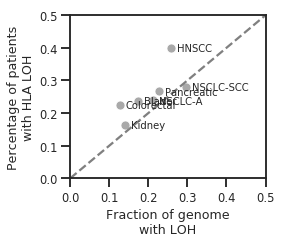

In [59]:
plt.figure(figsize=(3.5, 3))
sns.set_context('talk', font_scale=0.7)
plt.plot((0, 0.5), (0, 0.5), '--', color='grey')

ax = sns.scatterplot(x=cnv_category, y='Fraction', 
                     data=merged_freq_df_high_freq, color='darkgrey')

for i, txt in enumerate(range(len(merged_freq_df_high_freq))):
    ax.annotate(cancer_type_map[list(merged_freq_df_high_freq.Cancer_type)[i]], 
                (list(merged_freq_df_high_freq[cnv_category])[i]+0.015, 
                 list(merged_freq_df_high_freq.Fraction)[i]-0.01), size=10)
plt.xlabel('Fraction of genome\nwith LOH')
plt.ylabel('Percentage of patients\nwith HLA LOH')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.fraction_LOH_and_HLALOH.2021_06_25.pdf',
           bbox_inches='tight')

### TMB

In [60]:
print('Pan-cancer:', sp.mannwhitneyu(data_df[data_df.Has_HLALOH].Potential_neoantigens,
               data_df[~data_df.Has_HLALOH].Potential_neoantigens))
print('With HLA LOH:', data_df[data_df.Has_HLALOH].Potential_neoantigens.dropna().mean())
print('Without HLA LOH:', data_df[~data_df.Has_HLALOH].Potential_neoantigens.dropna().mean())


for tumor_type in cancer_types:
    print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.Has_HLALOH].Potential_neoantigens,
           data_df[(data_df.Cancer_type == tumor_type)&~data_df.Has_HLALOH].Potential_neoantigens)[1]*len(cancer_types))

g = sns.boxplot(x='Cancer_type', y='Potential_neoantigens', hue='Has_HLALOH', data=data_df,
           order=cancer_types, palette=[green, blue])
g.set_yscale("log")
g.set(xticklabels=[cancer_type_map[x] for x in cancer_types])

plt.xticks(rotation=90)

Pan-cancer: MannwhitneyuResult(statistic=23040.5, pvalue=0.005722805143241586)
With HLA LOH: 305.0373831775701
Without HLA LOH: 293.2309236947791
NSCLC_adenocarcinoma 0.04330538817996299
Colorectal 1.8815749789140894
NSCLC_SCC 1.7119602025169727
Kidney_RCC 2.963204976631291
Bladder 2.0394348047417195
Pancreatic 0.045197734563621035
Head_Neck 2.156102226412875


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Pan-cancer: MannwhitneyuResult(statistic=23694.0, pvalue=0.016323962241835337)
With HLA LOH: 58.5375
Without HLA LOH: 54.87403598971722
NSCLC_adenocarcinoma MannwhitneyuResult(statistic=570.0, pvalue=0.09642255514456127)
Colorectal MannwhitneyuResult(statistic=473.5, pvalue=0.166507232133218)
NSCLC_SCC MannwhitneyuResult(statistic=55.5, pvalue=0.023217704244630218)
Kidney_RCC MannwhitneyuResult(statistic=206.0, pvalue=0.49545614967095536)
Bladder MannwhitneyuResult(statistic=109.5, pvalue=0.24073314724560774)
Pancreatic MannwhitneyuResult(statistic=74.0, pvalue=0.26279647702382475)
Head_Neck MannwhitneyuResult(statistic=41.5, pvalue=0.321652016554505)


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

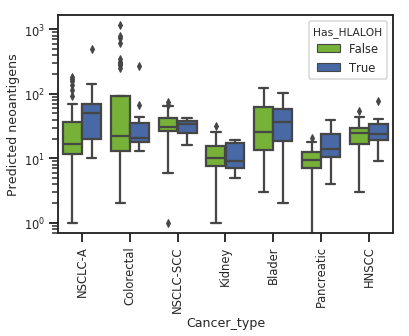

In [61]:
print('Pan-cancer:', sp.mannwhitneyu(data_df[data_df.Has_HLALOH].BINDING_antigen_strong_count,
               data_df[~data_df.Has_HLALOH].BINDING_antigen_strong_count))
print('With HLA LOH:', data_df[data_df.Has_HLALOH].BINDING_antigen_strong_count.dropna().mean())
print('Without HLA LOH:', data_df[~data_df.Has_HLALOH].BINDING_antigen_strong_count.dropna().mean())

for tumor_type in cancer_types:
    print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.Has_HLALOH].BINDING_antigen_strong_count,
           data_df[(data_df.Cancer_type == tumor_type)&~data_df.Has_HLALOH].BINDING_antigen_strong_count))

g = sns.boxplot(x='Cancer_type', y='BINDING_antigen_strong_count', hue='Has_HLALOH', data=data_df,
           order=cancer_types, palette=[green, blue])
g.set_yscale("log")
plt.ylabel('Predicted neoantigens')
g.set(xticklabels=[cancer_type_map[x] for x in cancer_types])

plt.xticks(rotation=90)

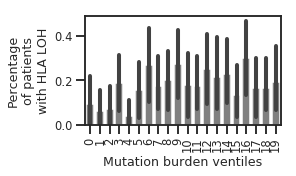

In [62]:
plt.figure(figsize=(3.5, 2))

tmb_df = data_df[['Potential_neoantigens', 'Has_HLALOH']].dropna()
tmb_df['Percentile'] = pd.qcut(tmb_df['Potential_neoantigens'], 20, labels=False)

sns.barplot(x='Percentile', y='Has_HLALOH', data=tmb_df, color='grey')
plt.xticks(rotation=90)
plt.xlabel('Mutation burden ventiles')
plt.ylabel('Percentage\nof patients\nwith HLA LOH')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.tmb_goldilocks.2021_06_25.pdf',
           bbox_inches='tight')

### Expression

In [63]:
# CD274 score
print('Pan-cancer:', sp.mannwhitneyu(data_df[data_df.Has_HLALOH].CD274,
               data_df[~data_df.Has_HLALOH].CD274))
print('With HLA LOH:', data_df[data_df.Has_HLALOH].CD274.median())
print('Without HLA LOH:', data_df[~data_df.Has_HLALOH].CD274.median())

for tumor_type in cancer_types:
    print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.Has_HLALOH].CD274,
           data_df[(data_df.Cancer_type == tumor_type)&~data_df.Has_HLALOH].CD274)[1]*len(cancer_types))

g = sns.boxplot(x='Cancer_type', y='CD274', hue='Has_HLALOH', data=data_df,
           order=cancer_types, palette=[green, blue])
g.set(xticklabels=[cancer_type_map[x] for x in cancer_types])
g.set_yscale("log")

plt.xticks(rotation=90)

Pan-cancer: MannwhitneyuResult(statistic=22912.0, pvalue=0.004580912734247475)
With HLA LOH: 14.2038
Without HLA LOH: 10.9557
NSCLC_adenocarcinoma 0.36455976506516596
Colorectal 0.1640381405218025
NSCLC_SCC 2.050453470943734
Kidney_RCC 3.2778666140028725
Bladder 3.0229245407346403
Pancreatic 1.8432895652546475
Head_Neck 2.754977786578909


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

### MSI

In [64]:
# MSI status
print('Pan-cancer:', sp.mannwhitneyu(data_df[data_df.Has_HLALOH].MSI_percentage,
               data_df[~data_df.Has_HLALOH].MSI_percentage))
print('With HLA LOH:', data_df[data_df.Has_HLALOH].MSI_percentage.median())
print('Without HLA LOH:', data_df[~data_df.Has_HLALOH].MSI_percentage.median())

for tumor_type in cancer_types:
    print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.Has_HLALOH].MSI_percentage,
           data_df[(data_df.Cancer_type == tumor_type)&~data_df.Has_HLALOH].MSI_percentage))

g = sns.boxplot(x='Cancer_type', y='MSI_percentage', hue='Has_HLALOH', data=data_df,
           order=cancer_types, palette=[green, blue])
plt.xticks(rotation=90)
g.set_yscale("log")
g.set(xticklabels=[cancer_type_map[x] for x in cancer_types])


Pan-cancer: MannwhitneyuResult(statistic=22974.5, pvalue=0.004521718405260812)
With HLA LOH: 0.08
Without HLA LOH: 0.03
NSCLC_adenocarcinoma MannwhitneyuResult(statistic=643.5, pvalue=0.27219854955943107)
Colorectal MannwhitneyuResult(statistic=477.0, pvalue=0.17499319956632292)
NSCLC_SCC MannwhitneyuResult(statistic=64.0, pvalue=0.047425205125439705)
Kidney_RCC MannwhitneyuResult(statistic=82.5, pvalue=0.0007145482119161073)
Bladder MannwhitneyuResult(statistic=121.0, pvalue=0.3777707081467909)
Pancreatic MannwhitneyuResult(statistic=42.5, pvalue=0.005944331898623412)
Head_Neck MannwhitneyuResult(statistic=41.5, pvalue=0.32000617435674217)


[[Text(0, 0, 'NSCLC-A'),
  Text(0, 0, 'Colorectal'),
  Text(0, 0, 'NSCLC-SCC'),
  Text(0, 0, 'Kidney'),
  Text(0, 0, 'Blader'),
  Text(0, 0, 'Pancreatic'),
  Text(0, 0, 'HNSCC')]]

### Oncovirus

In [65]:
# Oncovirus
oncoviruses = ['CMV', 'EBV', 'Fusobacterium_nucleatum', 'HBV_A', 'HBV_B', 'HBV_C', 
        'HBV_D', 'HBV_E', 'HBV_F', 'HBV_G', 'HBV_H', 'HPV_16', 'HPV_33', 'HPV_56']

In [66]:
data_df['HBV'] = data_df[['HBV_A', 'HBV_B', 'HBV_C', 
        'HBV_D', 'HBV_E', 'HBV_F', 'HBV_G', 'HBV_H']].sum(axis=1)
data_df['HPV'] = data_df[['HPV_16', 'HPV_33', 'HPV_56']].sum(axis=1)

In [67]:
# HBV
tumor_type = 'Liver'  
print('Total liver patients:', len(data_df[data_df.Cancer_type == 'Liver']))
print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.HBV > 0].Has_HLALOH,
       data_df[(data_df.Cancer_type == tumor_type)&data_df.HBV == 0].Has_HLALOH))
print(data_df[(data_df.Cancer_type == tumor_type)&data_df.HBV > 0].Has_HLALOH.mean(),
        data_df[(data_df.Cancer_type == tumor_type)&data_df.HBV == 0].Has_HLALOH.mean())


Total liver patients: 28
Liver MannwhitneyuResult(statistic=2450.0, pvalue=0.06861729894954298)
0.0 0.18196994991652754


In [68]:
data_df[data_df.Cancer_type == 'Liver'].Has_HLALOH.value_counts()

False    27
True      1
Name: Has_HLALOH, dtype: int64

In [69]:
# HPV
tumor_type = 'Cervical'      
print('Total Cervical patients:', len(data_df[data_df.Cancer_type == 'Cervical']))
print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.HPV > 0].Has_HLALOH,
       data_df[(data_df.Cancer_type == tumor_type)&data_df.HPV == 0].Has_HLALOH))
print(data_df[(data_df.Cancer_type == tumor_type)&data_df.HPV > 0].Has_HLALOH.mean(),
        data_df[(data_df.Cancer_type == tumor_type)&data_df.HPV == 0].Has_HLALOH.mean())


Total Cervical patients: 18
Cervical MannwhitneyuResult(statistic=1879.5, pvalue=0.23004767831455264)
0.2857142857142857 0.1777408637873754


In [70]:
# Fusobacterium_nucleatum
print('Overall:', sp.mannwhitneyu(data_df[data_df.Fusobacterium_nucleatum == 1].Has_HLALOH,
               data_df[data_df.Fusobacterium_nucleatum == 0].Has_HLALOH))
for tumor_type in ['Colorectal', 'Head_Neck']:      
    print(len(data_df[(data_df.Cancer_type == tumor_type)&data_df.Fusobacterium_nucleatum > 0]))
    print(tumor_type, sp.mannwhitneyu(data_df[(data_df.Cancer_type == tumor_type)&data_df.Fusobacterium_nucleatum > 0].Has_HLALOH,
               data_df[(data_df.Cancer_type == tumor_type)&data_df.Fusobacterium_nucleatum == 0].Has_HLALOH))
            

Overall: MannwhitneyuResult(statistic=8103.0, pvalue=0.006190185831936325)
26
Colorectal MannwhitneyuResult(statistic=6864.5, pvalue=0.11027448223133496)
7
Head_Neck MannwhitneyuResult(statistic=1270.5, pvalue=0.003259545494491064)


In [71]:
data_df[data_df.Fusobacterium_nucleatum == 1].Cancer_type.value_counts()

Colorectal              26
Head_Neck                7
NSCLC_adenocarcinoma     5
Melanoma                 4
Ovarian                  2
Cervical                 1
Kidney_RCC               1
Name: Cancer_type, dtype: int64

#### Plotting correlations

In [72]:
# Combine into a single figure
plt.figure(figsize=(8.5, 2.5))
sns.set_context('talk', font_scale=0.7)
gs = gridspec.GridSpec(1, 6) 

ax1 = plt.subplot2grid((1, 6), (0, 0))
sns.barplot(x='HLA LOH', y='BINDING_antigen_strong_count', ci=None,
            data=data_df, palette=[green, blue], order=[False, True])
plt.xticks(rotation=90)
plt.legend().remove()
plt.xticks([])
plt.xlabel('')
plt.ylabel('Neoantigen burden')

ax3 = plt.subplot2grid((1, 6), (0, 2))
sns.barplot(x='HLA LOH', y='CD274', ci=None,
            data=data_df, palette=[green, blue], order=[False, True])
plt.xticks(rotation=90)
plt.legend().remove()
plt.xticks([])
plt.xlabel('')
plt.ylabel('CD274 (PD-L1)\n expression')

ax4 = plt.subplot2grid((1, 6), (0, 4))
sns.barplot(x='HLA LOH', y='MSI_percentage', ci=None,
            data=data_df, palette=[green, blue], order=[False, True])
plt.xticks(rotation=90)
plt.legend().remove()
plt.xticks([])
plt.xlabel('')
plt.ylabel('Percentage\nMSI status')


plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.pan_correlations.2021_06_25.pdf',
           bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


##### Neoantigen trends

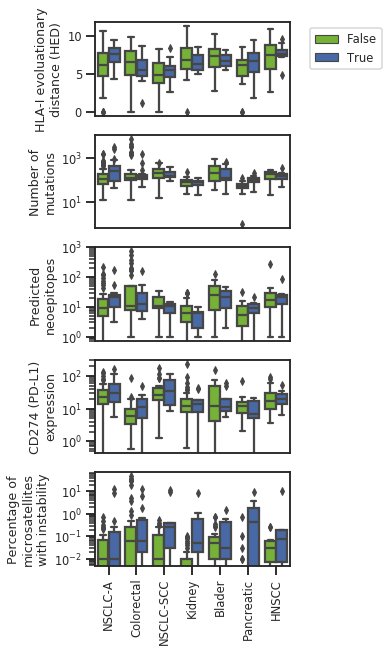

In [73]:
# Combine into a single figure
plt.figure(figsize=(3.5, 10))
sns.set_context('talk', font_scale=0.7)
gs = gridspec.GridSpec(5, 1) 


ax1 = plt.subplot2grid((5, 1), (0, 0))
sns.boxplot(x='Cancer_type', y='HED', hue='Has_HLALOH', 
            data=data_df, palette=[green, blue],
            order=cancer_types)
#g.set(xticklabels=['NSCLC-A', 'Breast', 'Melanoma', 'Colorectal', 'Head-neck'])
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.5, 1))
plt.xticks([])
plt.xlabel('')
plt.ylabel('HLA-I evoluationary\ndistance (HED)')
#plt.tight_layout()


ax2 = plt.subplot2grid((5, 1), (1, 0))
sns.boxplot(x='Cancer_type', y='Potential_neoantigens', hue='Has_HLALOH', data=data_df, palette=[green, blue],
           order=cancer_types)
plt.ylabel('Number of\nmutations')
ax2.set(yscale="log")
#plt.ylim(0, 2000)
plt.xticks(rotation=90)
plt.xticks([])
plt.xlabel('')
plt.legend().remove()


ax3 = plt.subplot2grid((5, 1), (2, 0))
sns.boxplot(x='Cancer_type', y='PRESENTATION_epitope_strong_count', 
                 hue='Has_HLALOH', data=data_df, 
            palette=[green, blue],
           order=cancer_types)
ax3.set(yscale="log")
plt.xticks(rotation=90)
plt.ylabel('Predicted\nneoepitopes')
#plt.ylim(0, 200)
plt.xticks([])
plt.xlabel('')
plt.legend().remove()

ax4 = plt.subplot2grid((5, 1), (3, 0))
sns.boxplot(x='Cancer_type', y='CD274', 
                 hue='Has_HLALOH', data=data_df, 
            palette=[green, blue],
           order=cancer_types)
ax4.set(yscale="log")
plt.xticks(rotation=90)
plt.ylabel('CD274 (PD-L1)\nexpression')
#plt.ylim(0, 200)
plt.xticks([])
plt.xlabel('')
plt.legend().remove()

ax5 = plt.subplot2grid((5, 1), (4, 0))
sns.boxplot(x='Cancer_type', y='MSI_percentage', 
                 hue='Has_HLALOH', data=data_df, 
            palette=[green, blue],
           order=cancer_types)
ax5.set(yscale="log")
plt.xticks(rotation=90)
plt.ylabel('Percentage of\nmicrosatellites\nwith instability')
#plt.ylim(0, 200)
plt.legend().remove()

ax5.set(xticklabels=[cancer_type_map[x] for x in cancer_types])
plt.xlabel('')

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/nextdb.HED_M_Neo.2021_06_25.pdf',
           bbox_inches='tight')

### Statstical test: are neoantigens allele-associated?

In [74]:
def get_sherpa_allele(x):
    try:
        return 'HLA-{0}{1}:{2}'.format(x.split('_')[1].upper(), x.split('_')[2], x.split('_')[3])
    except:
        return x

In [75]:
as_hla_loh_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/pancancer.dash_output.csv',
                        index_col=0)


In [76]:
as_hla_loh_df = as_hla_loh_df[~as_hla_loh_df['Sample'].str.contains('Post')]

In [77]:
as_hla_loh_df_with_loh = as_hla_loh_df[as_hla_loh_df.dash_deletion][['hla_locus', 'Sample']].drop_duplicates()

In [78]:
as_hla_loh_df['sherpa_allele'] = as_hla_loh_df['dash_allele'].apply(get_sherpa_allele)

In [79]:
as_hla_loh_df.head()

hla_locus  hla_locus_cntr        dash_allele hla_assign_allele  purity  \
0         A               1     hla_a_11_01_01        A*11:01:01    0.59   
1         A               2  hla_a_02_01_01_01     A*02:01:01:01    0.59   
2         B               1     hla_b_07_02_01        B*07:02:01    0.59   
3         B               2  hla_b_44_02_01_01     B*44:02:01:01    0.59   
4         C               1     hla_c_07_04_01        C*07:04:01    0.59   

   ploidy alternate_copy_number alternate_allelic_imbalance  \
0       2     0.954528661480121          0.1396995991856002   
1       2    1.1057150882186553          0.1396995991856002   
2       2    1.2609575305311944        5.46589459102549e-09   
3       2      0.92425847923387        5.46589459102549e-09   
4       2     1.217143898726644       0.0014113193379766864   

   alternate_deletion              dash_r  ... raw_dash_deletion  \
0               False  1.0101327646302274  ...             False   
1               False   0.978562589275474  ...             False   
2               False  1.1222587728426323  ...             False   
3               False  1.0166830101556927  ...             False   
4               False  1.1476173426890357  ...             False   

   dash_deletion  sequenza_majors  sequenza_minors  consistency_of_coverage  \
0          False              1.0              1.0                 0.562500   
1          False              1.0              1.0                 0.562500   
2          False              1.0              1.0                 0.586957   
3          False              1.0              1.0                 0.586957   
4          False              1.0              1.0                 0.608696   

   total_coverage  prediction_probability  secondary_check          Sample  \
0        1.958065                0.001676             True  DNA_S000460823   
1        1.958065                0.001676             True  DNA_S000460823   
2        2.153896                0.001239             True  DNA_S000460823   
3        2.153896                0.001239             True  DNA_S000460823   
4        2.376238                0.001102             True  DNA_S000460823   

  sherpa_allele  
0    HLA-A11:01  
1    HLA-A02:01  
2    HLA-B07:02  
3    HLA-B44:02  
4    HLA-C07:04  

[5 rows x 21 columns]

In [80]:
data_df.head()

sample_name_tumor AJCC_UICC_Stage_Group Cancer_type Simple_Stage  purity  \
0     DNA_S000460823                    II     Bladder           II    0.59   
1   DNA_D00689998_A1                    IV    Melanoma           IV    0.39   
2   DNA_D00689957_A1                   III  Colorectal          III    0.50   
3  DNA_D00689946_A2a                   III  Pancreatic          III    0.16   
4     DNA_S000465410                    II     Uterine           II    0.31   

   MATH  MSI_percentage  Cytolytic_score    CD274    CASP8  ...  \
0   NaN            0.03         7.313060   7.6641  29.6656  ...   
1   NaN            0.00         2.910320   2.4225  13.2090  ...   
2   NaN            0.65         4.947471  12.9711  22.0157  ...   
3   NaN            0.00         9.277136  15.6070  16.9710  ...   
4   NaN            0.88        11.480447   5.8557  15.0401  ...   

   BINDING_epitope_strong_count  PRESENTATION_antigen_strong_count  \
0                           NaN                                NaN   
1                           NaN                                NaN   
2                           NaN                                NaN   
3                           NaN                                NaN   
4                           NaN                                NaN   

   PRESENTATION_epitope_strong_count  Has_HLALOH  Allele_lost_A  \
0                                NaN       False              0   
1                                NaN       False              0   
2                                NaN        True              1   
3                                NaN       False              0   
4                                NaN       False              0   

   Allele_lost_B Allele_lost_C  HLA LOH  HBV  HPV  
0              0             0    False  0.0  0.0  
1              0             0    False  0.0  0.0  
2              1             1     True  0.0  0.0  
3              0             0    False  0.0  0.0  
4              0             0    False  0.0  0.0  

[5 rows x 755 columns]

In [81]:
# for patient, gene combination with LOH:
model = 'BINDING'
kept_neos, lost_neos, sample_neos, tt_neos = [], [], [], []
for sample, gene in zip(list(as_hla_loh_df_with_loh['Sample'][:]),
                        list(as_hla_loh_df_with_loh.hla_locus)[:]):
    try:
    
        if len(as_hla_loh_df[(as_hla_loh_df['Sample'] == sample)&
                             (as_hla_loh_df.hla_locus == gene)&(as_hla_loh_df.dash_deletion)]) == 1:
            # Get the lost and kept alleles
            lost_allele = list(as_hla_loh_df[(as_hla_loh_df['Sample'] == sample)&
                                             (as_hla_loh_df.hla_locus == gene)&
                                             (as_hla_loh_df.dash_deletion)].sherpa_allele)[0]
            kept_allele = list(as_hla_loh_df[(as_hla_loh_df['Sample'] == sample)&
                                             (as_hla_loh_df.hla_locus == gene)&
                                             (~as_hla_loh_df.dash_deletion)].sherpa_allele)[0]
            #print(lost_allele, kept_allele)

            # Number of neoantigens for kept and lost alleles
            neo_df = pd.read_csv('/rnd/users/rpyke/data/03-public_MS/applications/NeXTDB/merged_output/{0}.{1}.all.tab'.format(sample, model), 
                         sep='\t')
            tt_neos.append(list(data_df[data_df.sample_name_tumor == sample].Cancer_type)[0])
            kept_neos.append(len(neo_df[(neo_df.allele == kept_allele)&(neo_df.sherpa_calibrated < 0.5)]))
            lost_neos.append(len(neo_df[(neo_df.allele == lost_allele)&(neo_df.sherpa_calibrated < 0.5)]))
            sample_neos.append(sample)
    except:
        print(sample)

DNA_D00689957_A1
DNA_D00689957_A1
DNA_D00689957_A1
DNA_C00084278_1ba
DNA_D00689995_A1
DNA_D00689995_A1
DNA_D00689995_A1
DNA_D00689924_A
DNA_S000454926
DNA_S000454926
DNA_S000454926
DNA_S000443727
DNA_S000443727
DNA_S000443727


Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.


DNA_8472
DNA_S000439058
DNA_S000439058
DNA_246430
DNA_246430
DNA_S000449923
DNA_S000449913
DNA_S000449913
DNA_S000449913
DNA_S000449909
DNA_2NHVSAZI
DNA_2NHVSAZI
DNA_2NHVSAZI
DNA_QV2WNZ22
DNA_QV2WNZ22
DNA_QV2WNZ22
DNA_P98N5ARW
DNA_P98N5ARW
DNA_MBQQKA1D
DNA_MBQQKA1D
DNA_X3RYSA99
DNA_X3RYSA99
DNA_X3RYSA99
DNA_YOXMEA1E
DNA_YOXMEA1E
DNA_YOXMEA1E
DNA_ONVFVASX
DNA_ONVFVASX
DNA_ONVFVASX
DNA_RVPQPAPO
DNA_RVPQPAPO
DNA_RVPQPAPO
DNA_YINHDAYU
DNA_XCZ4EASP
DNA_KW15AA5Y
DNA_ILS32847PD9
DNA_ILS32847PD9
DNA_ILS32847PD9
DNA_124768F-5013
DNA_124768F-5013
DNA_1134036FA1-5013
DNA_1134036FA1-5013
DNA_1134036FA1-5013


In [82]:
len(kept_neos), len(lost_neos), len(sample_neos), len(tt_neos)

(180, 180, 180, 180)

In [83]:
neo_selection_df = pd.DataFrame({'Neoepitopes': kept_neos + lost_neos,
             'Allele Status': ['Kept' for x in kept_neos] + ['Lost' for x in lost_neos],
             'Patient': sample_neos + sample_neos,
            'Cancer_type': tt_neos + tt_neos})

neo_selection_df_ref = pd.merge(neo_selection_df[neo_selection_df['Allele Status'] == 'Kept'][['Patient', 'Cancer_type', 'Neoepitopes']],
         neo_selection_df[neo_selection_df['Allele Status'] == 'Lost'][['Patient', 'Neoepitopes']],
         on=['Patient'])

neo_selection_df_ref = neo_selection_df_ref.rename(columns={'Neoepitopes_x': 'Neoepitopes_Kept', 'Neoepitopes_y': 'Neoepitopes_Lost'})

neo_selection_df_ref['Ratio'] = np.log(neo_selection_df_ref.Neoepitopes_Lost / neo_selection_df_ref.Neoepitopes_Kept)

In [84]:
neo_selection_df.groupby('Allele Status').describe()

Neoepitopes                                                     
                    count       mean        std  min   25%   50%    75%    max
Allele Status                                                                 
Kept                180.0  64.033333  93.212912  1.0  17.0  30.0  68.50  521.0
Lost                180.0  67.322222  98.602336  2.0  17.0  33.5  68.25  503.0

In [85]:
sp.wilcoxon(list(neo_selection_df[neo_selection_df['Allele Status'] == 'Kept'].Neoepitopes),
               list(neo_selection_df[neo_selection_df['Allele Status'] == 'Lost'].Neoepitopes))

WilcoxonResult(statistic=5998.5, pvalue=0.011186492231339117)

In [86]:
for cancer_type in cancer_types:
    print(cancer_type, round(sp.wilcoxon(list(neo_selection_df[(neo_selection_df.Cancer_type == cancer_type)&(neo_selection_df['Allele Status'] == 'Kept')].Neoepitopes),
               list(neo_selection_df[(neo_selection_df.Cancer_type == cancer_type)&(neo_selection_df['Allele Status'] == 'Lost')].Neoepitopes))[1], 3))

NSCLC_adenocarcinoma 0.104
Colorectal 0.573
NSCLC_SCC 0.713
Kidney_RCC 0.152
Bladder 0.157
Pancreatic 0.925
Head_Neck 0.955
